### Requirements and Dataset

#### importing libs and dataset

In [157]:
# importing libs and dataset
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn import svm
import sklearn
import matplotlib
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)

df_original = pd.read_csv('dataset/online_shoppers_intention.csv')
df_original.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


### Exploratory data analysis

#### basic info

In [2]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [3]:
# shape, null values and shape

shape = df_original.shape
nulls = df_original.isna().sum()
nuniq = df_original.nunique()


print(f'NULLS SUM : \n {nulls}')
print(f'NUNIQUE SUM : \n {nuniq}')
print(f'SHAPE : \n {shape}')

NULLS SUM : 
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64
NUNIQUE SUM : 
 Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region             

#### Charts

In [166]:
# continuous and categorical
df = df_original.copy()

continuous = []
categorical = []

for c in df.columns[:-1]:
    if df.nunique()[c] >= 30:
        continuous.append(c)
    else:
        categorical.append(c)


In [167]:
# Plot settings
plot_settings = {
    'style': 'ggplot',  # Use 'ggplot' or another available style
    'palette': 'pastel',
    'title_fontsize': 16,
    'axis_fontsize': 12,
    'legend_title_fontsize': 14,
    'legend_fontsize': 12,
    'wedge_edgecolor': 'black',
    'autotext_fontsize': 12,
    'autotext_color': 'black',
    'autotext_weight': 'bold',
    'bar_colors': ['#FF9999', '#66B2FF'],
    'crosstab_colors': ['#FF9999', '#66B2FF']
}

# Set plot style
plt.style.use(plot_settings['style'])

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64


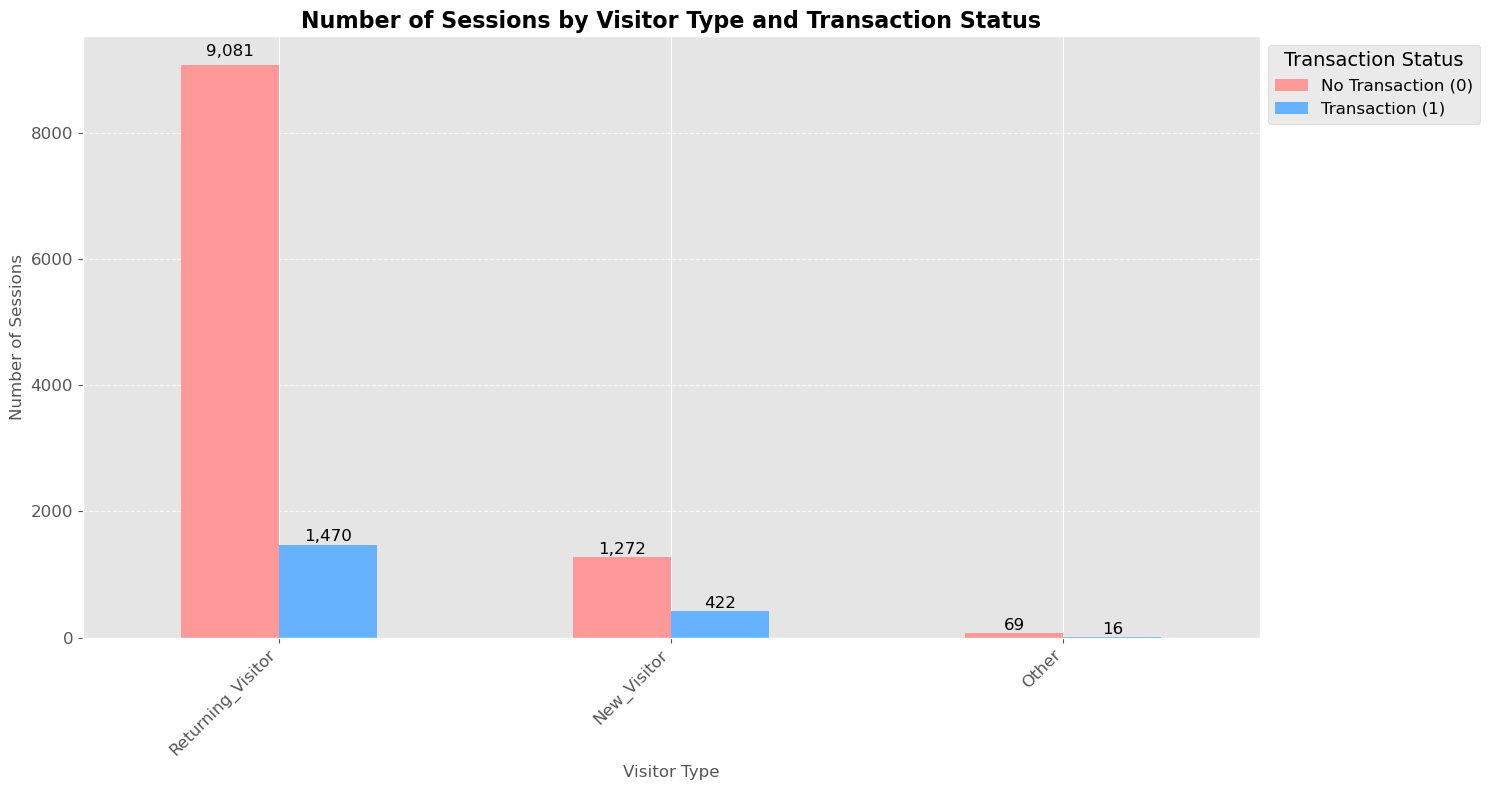

In [161]:
# Visitor Type and Total Transactions

# Print value counts
print(df['VisitorType'].value_counts())

# Filter DataFrame
new_df = df[df['VisitorType'] != 'Other'][['VisitorType', 'Revenue']]

# Group by VisitorType and Revenue
revenue_visitor_df = df.groupby(['VisitorType', 'Revenue']).size().unstack(fill_value=0).reset_index()
revenue_visitor_df.columns = ['VisitorType', 'No Transaction (0)', 'Transaction (1)']

# Total Sessions
revenue_visitor_df['Total Sessions'] = revenue_visitor_df['No Transaction (0)'] + revenue_visitor_df['Transaction (1)']
revenue_visitor_df = revenue_visitor_df.sort_values(by='Total Sessions', ascending=False).drop(columns='Total Sessions')

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
revenue_visitor_df.plot(kind='bar', x='VisitorType', stacked=False, color=plot_settings['bar_colors'], ax=ax)
plt.title('Number of Sessions by Visitor Type and Transaction Status', fontsize=plot_settings['title_fontsize'], fontweight='bold')
plt.xlabel('Visitor Type', fontsize=plot_settings['axis_fontsize'])
plt.ylabel('Number of Sessions', fontsize=plot_settings['axis_fontsize'])

# Add value labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * height, f'{height:,}', 
                ha='center', va='bottom', fontsize=plot_settings['axis_fontsize'], color='black')

plt.xticks(rotation=45, ha='right', fontsize=plot_settings['axis_fontsize'])
plt.yticks(fontsize=plot_settings['axis_fontsize'])
plt.legend(title='Transaction Status', title_fontsize=plot_settings['legend_title_fontsize'], fontsize=plot_settings['legend_fontsize'], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('n_by_visitor_type.png')
plt.show()

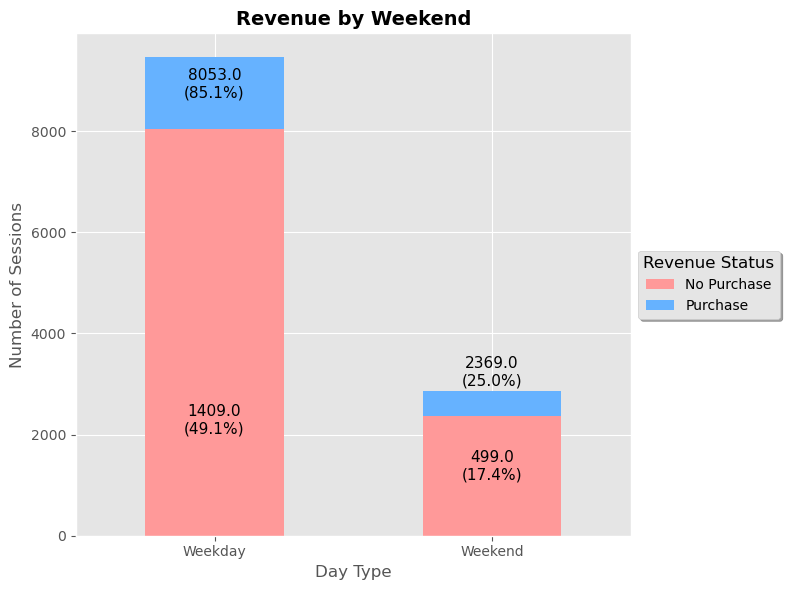

In [162]:
# Create crosstab day type x revenue 
crosstab = pd.crosstab(df['Weekend'], df['Revenue'])
crosstab.columns = ['No Purchase', 'Purchase']

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
crosstab.plot(kind='bar', stacked=True, ax=ax, color=plot_settings['crosstab_colors'])
plt.ylabel('Number of Sessions', fontsize=12)
plt.xlabel('Day Type', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], fontsize=10, rotation=0)
plt.title('Revenue by Weekend', fontsize=14, fontweight='bold')

# Rename legend categories
plt.legend(title='Revenue Status', labels=['No Purchase', 'Purchase'], fontsize=10, title_fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)

# Add data labels
for i, patch in enumerate(ax.patches):
    height = patch.get_height()
    if height > 0:
        total_sessions = crosstab.iloc[i // 2].sum()
        percentage = height / total_sessions * 100
        ax.annotate(f'{height}\n({percentage:.1f}%)', 
                    xy=(patch.get_x() + patch.get_width() / 2, height), 
                    xytext=(0, 20), 
                    textcoords='offset points', 
                    ha='center', 
                    va='bottom', 
                    fontsize=11, 
                    color='black')

plt.tight_layout()
plt.savefig('revenue_by_weekend.png', dpi=300)
plt.show()


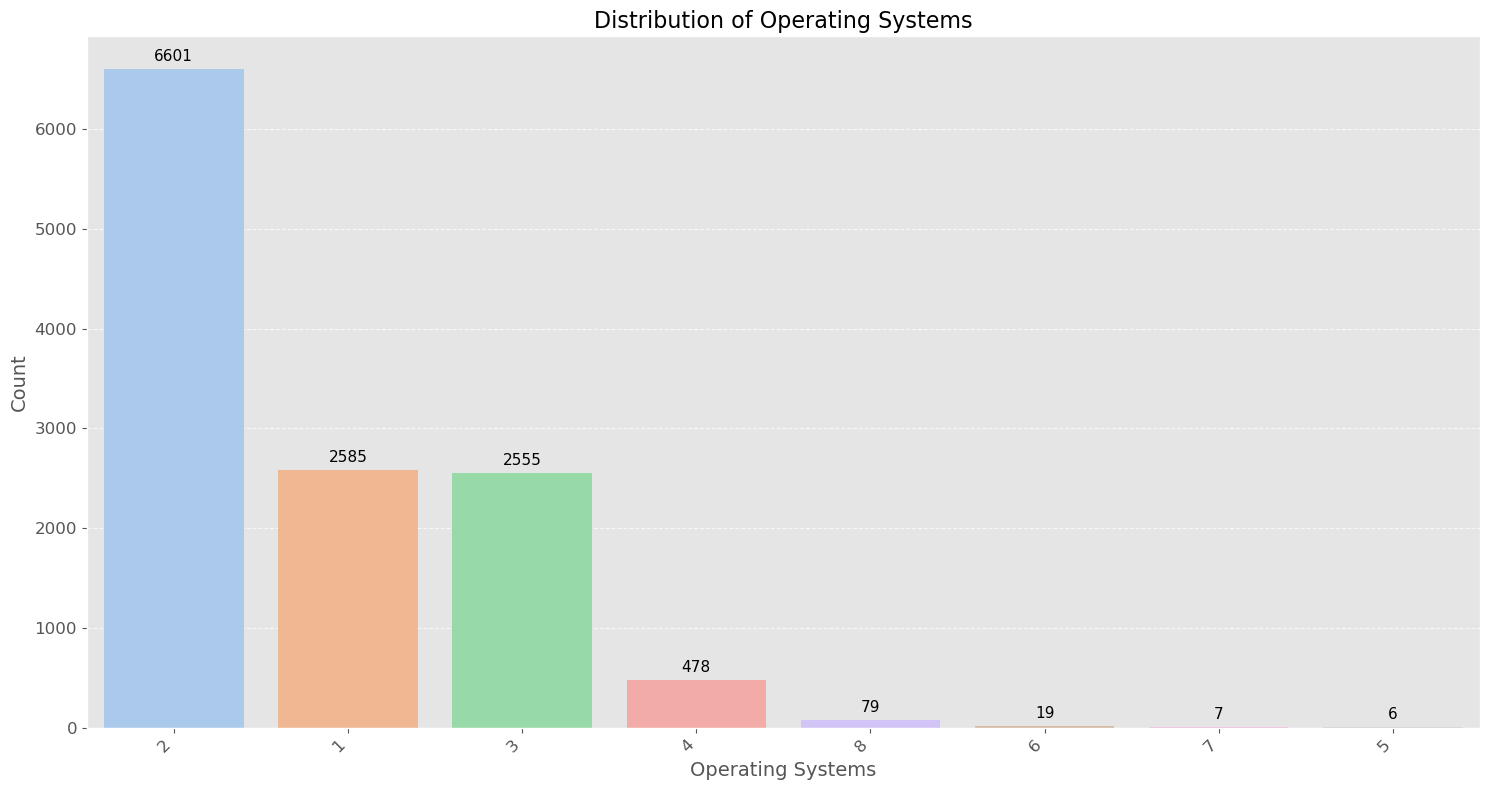

In [163]:
# OperatingSystems distribution
os_df = df['OperatingSystems'].value_counts().reset_index()
os_df.columns = ['OperatingSystems', 'count']
os_df_sorted = os_df.sort_values(by='count', ascending=False)

# Plotting
plt.figure(figsize=(15, 8))
barplot = sns.barplot(x='OperatingSystems', y='count', data=os_df_sorted, palette='pastel', order=os_df_sorted['OperatingSystems'])

# Improve aesthetics
plt.xlabel('Operating Systems', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Operating Systems', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability

# Add value labels on top of bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=11)

# Display the plot
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.savefig('o_s_dist.png', dpi=300)
plt.show()

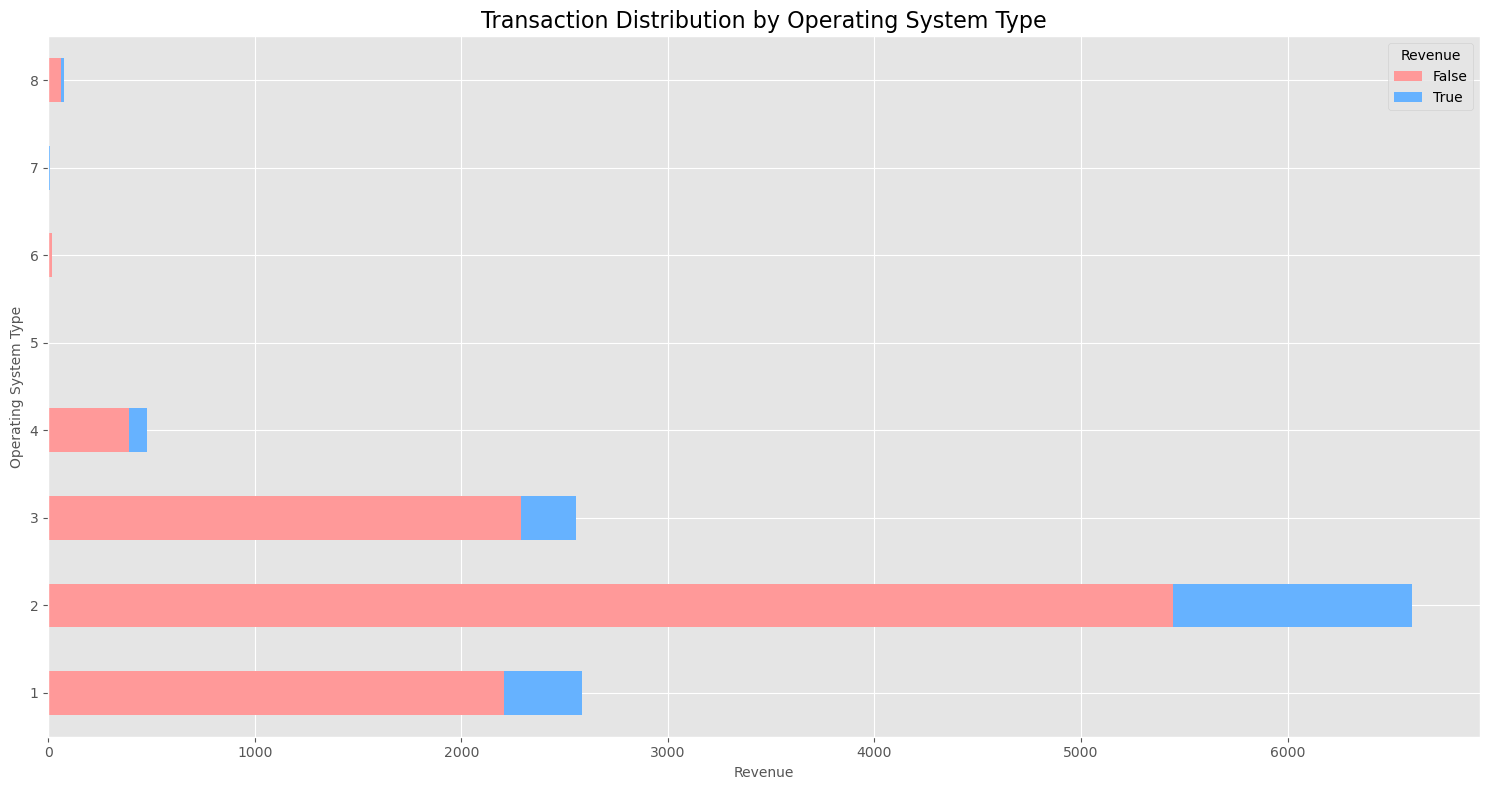

In [164]:
# Transaction Distribution by Operating System Type
# Aggregate and sort DataFrame
TrafficType_df = df[['TrafficType']].value_counts().reset_index(name='count')
TrafficType_df.columns = ['TrafficType', 'count']
TrafficType_df = TrafficType_df.sort_values(by='count', ascending=False)  # Sort by count

# Create horizontal stacked bar chart
contingency_table = pd.crosstab(df['OperatingSystems'], df['Revenue'])
fig, ax = plt.subplots(figsize=(15, 8))
contingency_table.plot(kind='barh', stacked=True, color=plot_settings['bar_colors'],  ax=ax)
plt.title('Transaction Distribution by Operating System Type', fontsize=16)
plt.xlabel('Revenue', fontsize=10)
plt.ylabel('Operating System Type', fontsize=10)
plt.tight_layout()
plt.savefig('transition_os.png', dpi=300)
plt.show()


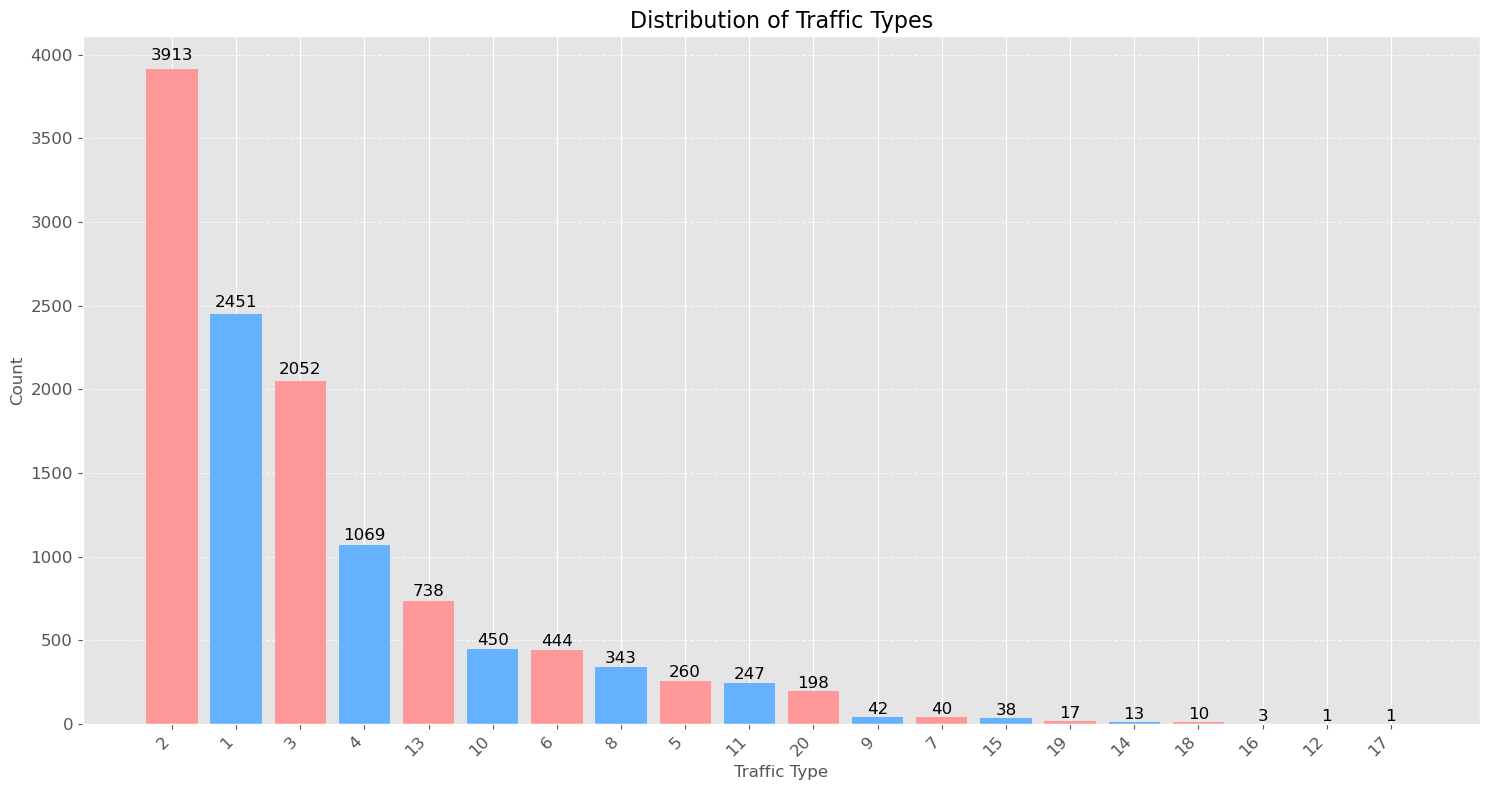

In [169]:
# Distribution of Traffic Types
# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(TrafficType_df['TrafficType'].astype(str), TrafficType_df['count'], color=plot_settings['bar_colors'])

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01*yval, int(yval), ha='center', va='bottom', fontsize=plot_settings['autotext_fontsize'], color=plot_settings['autotext_color'])

# Improve aesthetics
plt.title('Distribution of Traffic Types', fontsize=plot_settings['title_fontsize'])
plt.xlabel('Traffic Type', fontsize=plot_settings['axis_fontsize'])
plt.ylabel('Count', fontsize=plot_settings['axis_fontsize'])
plt.xticks(rotation=45, ha='right', fontsize=plot_settings['axis_fontsize'])
plt.yticks(fontsize=plot_settings['axis_fontsize'])
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability

plt.tight_layout()
plt.savefig('trafic_type.png', dpi=300)
plt.show()

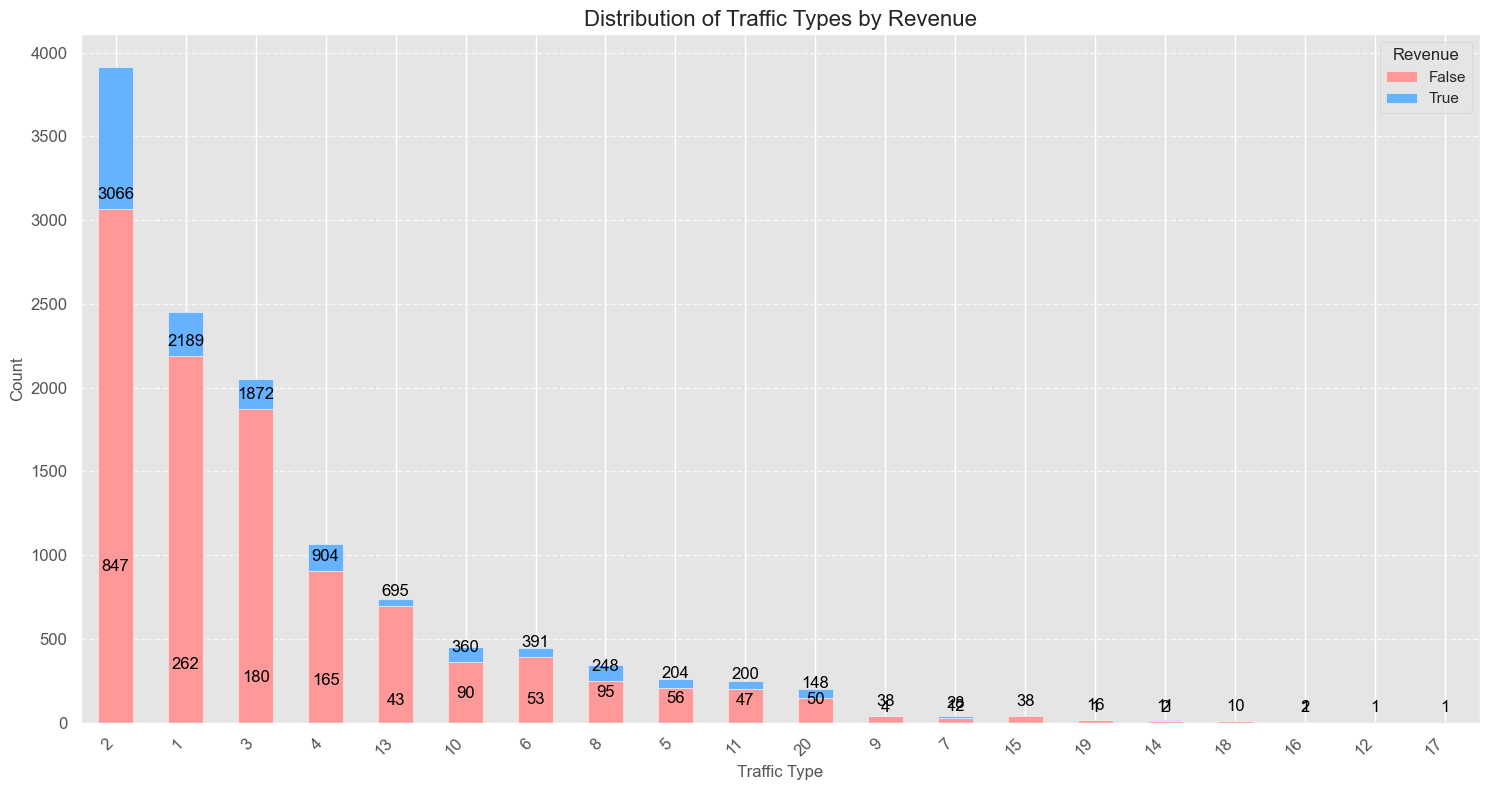

In [213]:
# Distribution of Traffic Types by Revenue
# Create a crosstab DataFrame
crosstab_df = pd.crosstab(df['TrafficType'], df['Revenue'])

# Sort the DataFrame by the total counts for each TrafficType in ascending order
crosstab_df['Total'] = crosstab_df.sum(axis=1)
crosstab_df = crosstab_df.sort_values(by='Total', ascending = False)
crosstab_df = crosstab_df.drop(columns='Total')  # Drop the 'Total' column used for sorting

# Plotting
plt.style.use(plot_settings['style'])  # Apply the style
fig, ax = plt.subplots(figsize=(15, 8))  # Adjust size for better readability

# Plot stacked bar chart
crosstab_df.plot(kind='bar', stacked=True, ax=ax, color=plot_settings['crosstab_colors'])

# Add labels on top of bars
for container in ax.containers:
    for bar in container:
        yval = bar.get_height()
        if yval > 0:
            # Adjust label position to avoid overlapping
            ax.annotate(f'{int(yval)}',
                        xy=(bar.get_x() + bar.get_width() / 2, yval),
                        xytext=(0, 5),  # Adjust this offset if needed
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=plot_settings['autotext_fontsize'],
                        color=plot_settings['autotext_color'])

# Improve aesthetics
plt.title('Distribution of Traffic Types by Revenue', fontsize=plot_settings['title_fontsize'])
plt.xlabel('Traffic Type', fontsize=plot_settings['axis_fontsize'])
plt.ylabel('Count', fontsize=plot_settings['axis_fontsize'])
plt.xticks(rotation=45, ha='right', fontsize=plot_settings['axis_fontsize'])
plt.yticks(fontsize=plot_settings['axis_fontsize'])
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability

plt.tight_layout()
# Save the plot if needed
# plt.savefig('traffic_type_revenue.png', dpi=300)

plt.show()

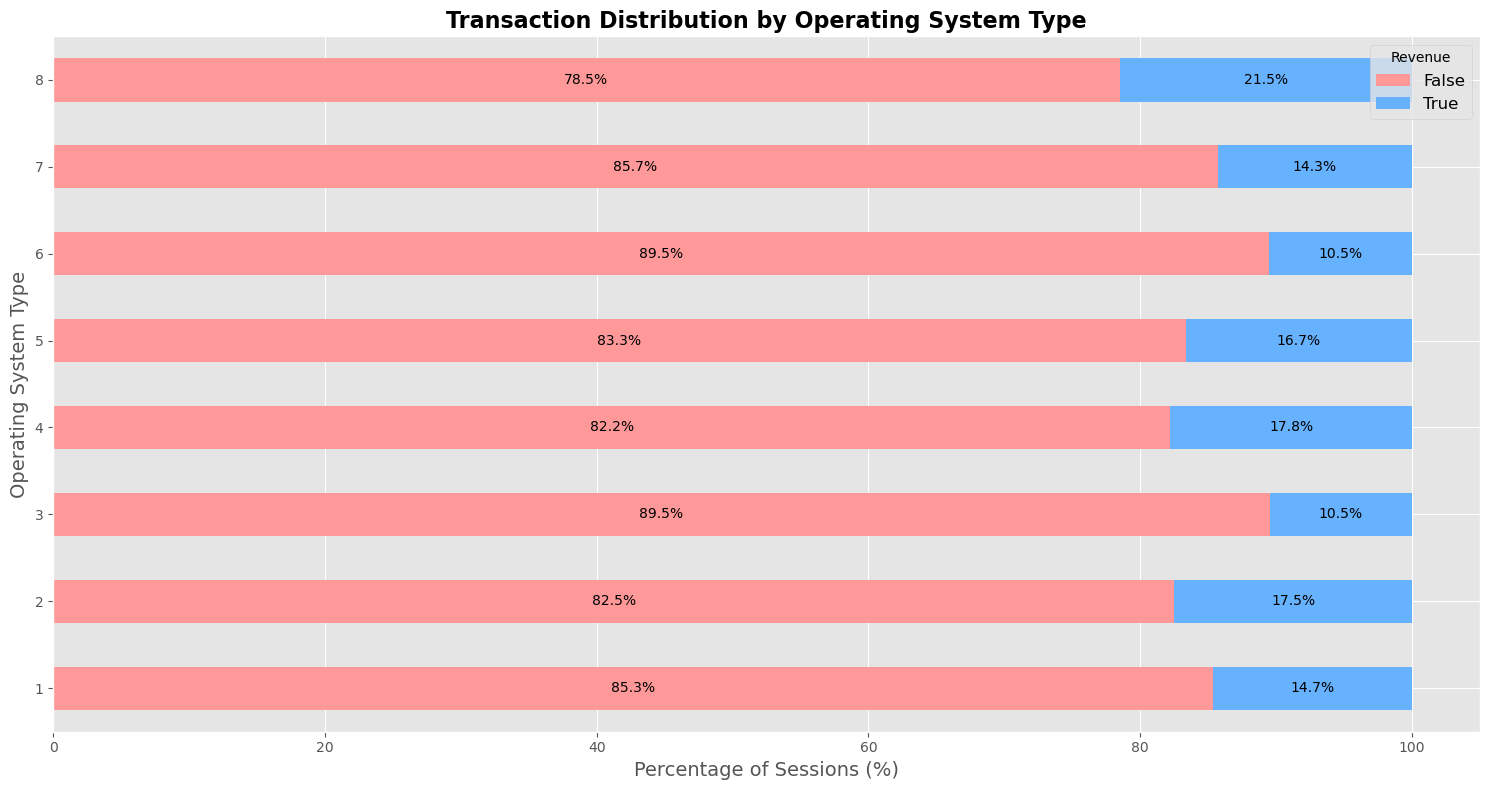

In [172]:
# Create horizontal stacked bar chart for Transaction Distribution by Operating System Type
contingency_table = pd.crosstab(df['OperatingSystems'], df['Revenue'])

# Calculate percentage proportions for each category within OperatingSystems
contingency_table_percent = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(15, 8))
contingency_table_percent.plot(kind='barh', stacked=True, color=plot_settings['bar_colors'], ax=ax)

# Add title and labels
plt.title('Transaction Distribution by Operating System Type', fontsize=16, fontweight='bold')
plt.xlabel('Percentage of Sessions (%)', fontsize=14)
plt.ylabel('Operating System Type', fontsize=14)

# Add legend and adjust layout
plt.legend(title='Revenue', loc='upper right', fontsize=12)
plt.tight_layout()

# Annotate the bars with percentage proportions
for i, (index, row) in enumerate(contingency_table_percent.iterrows()):
    cumulative_sum = 0
    for j, (category, value) in enumerate(row.items()):
        if value > 0:
            ax.text(cumulative_sum + value / 2, i, f'{value:.1f}%', va='center', ha='center', fontsize=10, color='black')
        cumulative_sum += value
plt.savefig('Transaction Distribution by Operating System Type.png', dpi=300)
plt.show()

## ML MODEL

In [61]:
# maps

visitor_map = {'Returning_Visitor':1,'New_Visitor':2,'Other':3}
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}


df_original['Month'] = df_original['Month'].replace(month_mapping).astype(int)
df_original['VisitorType'] = df_original['VisitorType'].replace(visitor_map)
df_original[['Weekend', 'Revenue']] = df_original[['Weekend', 'Revenue']].astype(int)

In [62]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

# Seed 
seed = 100

# Separa X e y
X = df_original.iloc[:, 0:17]  
y = df_original.iloc[:, 17] 

# Cria o balanceador SMOTE
smote_bal = SMOTE(random_state = seed)

# Aplica o balanceador
X_res, y_res = smote_bal.fit_resample(X, y)

In [63]:
print(y_res.value_counts())
print(y_res.shape)
print(X_res.shape)

0    10422
1    10422
Name: Revenue, dtype: int64
(20844,)
(20844, 17)


In [64]:
# X = X_res
# y = y_res

X = X_res.head(1000)
y = y_res.head(1000)

# Divisão em Dados de Treino e Teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Modelo SVM V1
#### Modelo Base com Kernel Linear

- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [65]:
model_v1 = svm.SVC(kernel = 'linear')

In [66]:
# Treinamento
start = time.time()
model_v1.fit(X_train, y_train)
end = time.time()
print('Training time was\n :', end - start)

Training time was
 : 54.28490948677063


In [67]:
forecasts_v1 = model_v1.predict(X_test)

In [139]:
# Metrics and Metadata Dictionary
SVM_dict_v1 = {'Model':'SVM',
               'Version':'1',
               'Kernel':'Linear',
               'Precision':precision_score(forecasts_v1, y_test),
               'Recall':recall_score(forecasts_v1, y_test),
               'F1 Score':f1_score(forecasts_v1, y_test),
               'Accuracy':accuracy_score(forecasts_v1, y_test),
               'AUC':roc_auc_score(y_test, forecasts_v1)}

# Print
print("Métricas em Teste:\n")
SVM_dict_v1

Métricas em Teste:



{'Model': 'SVM',
 'Version': '1',
 'Kernel': 'Linear',
 'Precision': 0.44,
 'Recall': 0.8461538461538461,
 'F1 Score': 0.5789473684210525,
 'Accuracy': 0.9466666666666667,
 'AUC': 0.7163636363636363}

In [140]:
# StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [141]:
X_train_scaled

array([[-0.59034343, -0.4057962 , -0.31756214, ..., -0.75751167,
        -0.33597259, -0.54433105],
       [-0.59034343, -0.4057962 , -0.31756214, ..., -0.41048407,
        -0.33597259,  1.83711731],
       [ 0.07887179, -0.33374316, -0.31756214, ..., -0.75751167,
        -0.33597259, -0.54433105],
       ...,
       [-0.59034343, -0.4057962 , -0.31756214, ..., -0.41048407,
         2.97643326, -0.54433105],
       [ 0.07887179, -0.16343599, -0.31756214, ..., -0.41048407,
         2.97643326,  1.83711731],
       [-0.59034343, -0.4057962 , -0.31756214, ..., -0.41048407,
        -0.33597259, -0.54433105]])

In [142]:
X_test_scaled

array([[ 0.4134794 , -0.0258802 , -0.31756214, ..., -0.06345648,
        -0.33597259, -0.54433105],
       [-0.25573582, -0.26169013, -0.31756214, ..., -0.41048407,
        -0.33597259, -0.54433105],
       [ 1.08269462,  1.52457009,  4.89244178, ..., -0.75751167,
        -0.33597259, -0.54433105],
       ...,
       [-0.59034343, -0.4057962 , -0.31756214, ..., -0.41048407,
        -0.33597259, -0.54433105],
       [-0.25573582, -0.4057962 , -0.31756214, ...,  0.63059872,
        -0.33597259,  1.83711731],
       [-0.59034343, -0.4057962 , -0.31756214, ..., -0.75751167,
        -0.33597259,  1.83711731]])

### Model SVM V2

In [143]:
model_v2 = svm.SVC(kernel = 'linear')

In [144]:
# traning
start = time.time()
model_v2.fit(X_train_scaled, y_train)
end = time.time()
print('Training time was\n :', end - start)

Training time was
 : 0.008007287979125977


In [145]:
# forecast
forecasts_v2 = model_v2.predict(X_test_scaled)

In [146]:
# Metrics and Metadata Dictionary
SVM_dict_v2 = {'Model':'SVM',
               'Version':'2',
               'Kernel':'Linear with Standardized Data',
               'Precision':precision_score(forecasts_v2, y_test),
               'Recall':recall_score(forecasts_v2, y_test),
               'F1 Score':f1_score(forecasts_v2, y_test),
               'Accuracy':accuracy_score(forecasts_v2, y_test),
               'AUC':roc_auc_score(y_test, forecasts_v2)}
# Print
print("Métricas em Teste:\n")
SVM_dict_v2

Métricas em Teste:



{'Model': 'SVM',
 'Version': '2',
 'Kernel': 'Linear with Standardized Data',
 'Precision': 0.48,
 'Recall': 0.8571428571428571,
 'F1 Score': 0.6153846153846153,
 'Accuracy': 0.95,
 'AUC': 0.7363636363636362}

### Modelo SVM V3

In [147]:
# model 3
model_v3 = svm.SVC(kernel = 'rbf')

# Valores para o grid
C_range = np.array([50., 100., 200.])
gamma_range = np.array([0.3*0.001,0.001,3*0.001])

# Grid de hiperparâmetros
svm_param_grid = dict(gamma = gamma_range, C = C_range)

# Grid Search
start = time.time()
model_v3_grid_search_rbf = GridSearchCV(model_v3, svm_param_grid, cv = 3)

# Treinamento
model_v3_grid_search_rbf.fit(X_train_scaled, y_train)
end = time.time()
print('Training time was\n :', end - start)

# Acurácia em Treino
print(f"Accuracy: {model_v3_grid_search_rbf.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {model_v3_grid_search_rbf.best_params_}")

Training time was
 : 0.1080026626586914
Accuracy: 94.86%

Hiperparâmetros Ideais: {'C': 50.0, 'gamma': 0.003}


In [148]:
# forecasting
forecasts_v3 = model_v3_grid_search_rbf.predict(X_test_scaled)

In [149]:
# Metrics and Metadata Dictionary
SVM_dict_v3 = {'Model':'SVM',
               'Version':'3',
               'Kernel':'RBF Standardized ',
               'Precision':precision_score(forecasts_v3, y_test),
               'Recall':recall_score(forecasts_v3, y_test),
               'F1 Score':f1_score(forecasts_v3, y_test),
               'Accuracy':accuracy_score(forecasts_v3, y_test),
               'AUC':roc_auc_score(y_test, forecasts_v3)}

# Print
print("Métricas em Teste:\n")
SVM_dict_v3

Métricas em Teste:



{'Model': 'SVM',
 'Version': '3',
 'Kernel': 'RBF Standardized ',
 'Precision': 0.52,
 'Recall': 0.8666666666666667,
 'F1 Score': 0.65,
 'Accuracy': 0.9533333333333334,
 'AUC': 0.7563636363636363}

### Modelo SVM V4

In [150]:
# Cria o modelo
model_v4 = svm.SVC(kernel = 'poly')

# grid values
r_range =  np.array([0.5, 1])
gamma_range =  np.array([0.001, 0.01])
d_range = np.array([2,3, 4])

# Grid  hyperparameters
param_grid_poly = dict(gamma = gamma_range, degree = d_range, coef0 = r_range)

# Grid Search
start = time.time()
model_v4_grid_search_poly = GridSearchCV(model_v4, param_grid_poly, cv = 3)

# train
model_v4_grid_search_poly.fit(X_train_scaled, y_train)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Accuracy
print(f"Acurácia em Treinamento: {model_v4_grid_search_poly.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {model_v4_grid_search_poly.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 0.10385370254516602
Acurácia em Treinamento: 94.86%

Hiperparâmetros Ideais: {'coef0': 1.0, 'degree': 3, 'gamma': 0.01}


In [151]:
# forecasting
forecasts_v4 = model_v4_grid_search_poly.predict(X_test_scaled)

In [152]:
# Metrics and Metadata Dictionary
SVM_dict_v4 = {'Model':'SVM',
               'Version':'4',
               'Kernel':'Polynomial Standardized',
               'Precision':precision_score(forecasts_v4, y_test),
               'Recall':recall_score(forecasts_v4, y_test),
               'F1 Score':f1_score(forecasts_v4, y_test),
               'Accuracy':accuracy_score(forecasts_v4, y_test),
               'AUC':roc_auc_score(y_test, forecasts_v4)}

# Print
print("Métricas em Teste:\n")
SVM_dict_v4

Métricas em Teste:



{'Model': 'SVM',
 'Version': '4',
 'Kernel': 'Polynomial Standardized',
 'Precision': 0.4,
 'Recall': 0.7692307692307693,
 'F1 Score': 0.5263157894736842,
 'Accuracy': 0.94,
 'AUC': 0.6945454545454546}

## review

In [155]:
# Concatena todos os dicionários em um dataframe do Pandas
review = pd.DataFrame({'SVM_Model_1':pd.Series(SVM_dict_v1),
                       'SVM_Model_2':pd.Series(SVM_dict_v2),
                       'SVM_Model_3':pd.Series(SVM_dict_v3),
                       'SVM_Model_4':pd.Series(SVM_dict_v4)})

In [156]:
review

,SVM_Model_1,SVM_Model_2,SVM_Model_3,SVM_Model_4
Model,SVM,SVM,SVM,SVM
Version,1,2,3,4
Kernel,Linear,Linear with Standardized Data,RBF Standardized,Polynomial Standardized
Precision,0.44,0.48,0.52,0.4
Recall,0.846154,0.857143,0.866667,0.769231
F1 Score,0.578947,0.615385,0.65,0.526316
Accuracy,0.946667,0.95,0.953333,0.94
AUC,0.716364,0.736364,0.756364,0.694545
